Dyad Comparison (by author role)
===

Goal:
 - Do certain author role pairs reciprocate more? (Logistic regression)
 - Do certain author role pairs last longer than others? (Survival analysis)
 - Do certain author roles have more interactions? (Linear regression)
 
A next step: does the network structure have implications for the length of time that a relationship lasts?

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
import os
import re
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
import sqlite3
from tqdm import tqdm
import random
import pickle
from datetime import datetime
import bisect

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

import networkx as nx
import scipy.stats

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [9]:
working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/dyad_growth"
assert os.path.exists(working_dir)

In [10]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
figures_dir = os.path.join(git_root_dir, 'figures')
figures_dir

'/panfs/roc/groups/3/srivbane/levon003/repos/sna-social-support/figures'

In [11]:
start_date = datetime.fromisoformat('2005-01-01')
start_timestamp = int(start_date.timestamp() * 1000)
end_date = datetime.fromisoformat('2016-06-01')
end_timestamp = int(end_date.timestamp() * 1000)
subset_start_date = datetime.fromisoformat('2014-01-01')
subset_start_timestamp = int(subset_start_date.timestamp() * 1000)

### Read in the data

In [12]:
# load the list of valid users
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_user_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_user_ids.txt"), 'r') as infile:
    for line in infile:
        user_id = line.strip()
        if user_id == "":
            continue
        else:
            valid_user_ids.add(int(user_id))
len(valid_user_ids)

362345

In [13]:
# load the list of valid sites
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_site_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_site_ids.txt"), 'r') as infile:
    for line in infile:
        site_id = line.strip()
        if site_id == "":
            continue
        else:
            valid_site_ids.add(int(site_id))
len(valid_site_ids)

411269

In [14]:
# read the journal metadata with author type info added
s = datetime.now()
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
journal_metadata_filepath = os.path.join(author_type_dir, "journal_metadata_with_author_type.df")
journal_df = pd.read_feather(journal_metadata_filepath)
print(datetime.now() - s)
len(journal_df)

0:00:29.119918


15850052

In [15]:
# as a quick fix for invalid dates in journals, when created_at is 0 we use the updated_at instead
# note that only 41 updates have this issue
invalid_created_at = journal_df.created_at <= 0
journal_df.loc[invalid_created_at, 'created_at'] = journal_df.loc[invalid_created_at, 'updated_at']

In [16]:
health_cond_filepath = os.path.join("/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata", "assigned_health_conditions.feather")
user_health_conds_df = pd.read_feather(health_cond_filepath)
len(user_health_conds_df)

714874

In [17]:
np.sum(user_health_conds_df[user_health_conds_df.user_id.isin(valid_user_ids)].assigned_health_cond != 'None') / len(user_health_conds_df[user_health_conds_df.user_id.isin(valid_user_ids)])

0.5782527701499952

In [18]:
for cond, count in Counter(user_health_conds_df[user_health_conds_df.user_id.isin(valid_user_ids)].assigned_health_cond).most_common():
    print(f"{cond} & {count:,} & {count/len(valid_user_ids)*100:.2f}\\% \\\\")

None & 152,818 & 42.17\% \\
Cancer & 109,339 & 30.18\% \\
Other & 37,556 & 10.36\% \\
Surgery/Transplantation & 15,415 & 4.25\% \\
Injury & 12,910 & 3.56\% \\
Cardiovascular/Stroke & 12,685 & 3.50\% \\
Neurological Condition & 9,376 & 2.59\% \\
Infant/Childbirth & 7,952 & 2.19\% \\
Condition Unknown & 2,252 & 0.62\% \\
Congenital/Immune Disorder & 2,042 & 0.56\% \\


In [19]:
# read the user author type dataframe
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
user_patient_proportions_filepath = os.path.join(author_type_dir, 'user_patient_proportions.df')
user_df = pd.read_feather(user_patient_proportions_filepath)
len(user_df)

362345

In [20]:
# read the user->user interactions dataframe
metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
u2u_df = pd.read_feather(os.path.join(metadata_dir,"u2u_df.feather"))
len(u2u_df)

14812407

In [21]:
# read the site-level metadata
site_metadata_working_dir = "/home/srivbane/shared/caringbridge/data/derived/site_metadata"
site_metadata_filepath = os.path.join(site_metadata_working_dir, "site_metadata.feather")
site_metadata_df = pd.read_feather(site_metadata_filepath)
len(site_metadata_df)

840943

In [22]:
# percent of valid sites that self-report a health condition
site_subset = site_metadata_df[site_metadata_df.site_id.isin(valid_site_ids)]
np.sum(site_subset.healthCondition_category.notnull()) / len(site_subset)

0.5335096980321882

In [23]:
# currently not necessary, since we use the processed user->user interactions...
# read in the interactions dataframe
#metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
#author_to_site = os.path.join(metadata_dir, "interaction_metadata.h5")
#ints_df = pd.read_hdf(author_to_site)
#len(ints_df)

## Filter to only valid users and sort data

Also create initiations dataframe

In [24]:
user_df = user_df[user_df.user_id.isin(valid_user_ids)]
len(user_df)

362345

In [25]:
u2u_df = u2u_df[(u2u_df.from_user_id.isin(valid_user_ids))&(u2u_df.to_user_id.isin(valid_user_ids))]
len(u2u_df)

10441676

In [26]:
u2u_df = u2u_df.sort_values(by='created_at', ascending=True)
init_df = u2u_df.drop_duplicates(subset=['from_user_id', 'to_user_id'], keep='first')

In [27]:
u2u_df.head()

,from_user_id,to_user_id,created_at,int_type
13689525,23616609,20085865,1101191820000,amps
10935800,10499159,20085865,1101191820000,amps
10935801,10499159,20085865,1102603140000,amps
2789662,1217109,1,1103856900000,amps
8914,122,48,1117645589000,guestbook


## Forming relationships and labeling them

In [28]:
dyad_ids_dict = {}
dyad_ids_list = []
global_dyad_counter = 0
for row in tqdm(init_df.itertuples(), total=len(init_df)):
    tup = (row.from_user_id, row.to_user_id)
    r_tup = (row.to_user_id, row.from_user_id)
    if r_tup in dyad_ids_dict:
        dyad_id = dyad_ids_dict[r_tup]
        dyad_ids_dict[tup] = dyad_id
    else:
        dyad_id = global_dyad_counter
        global_dyad_counter += 1
        dyad_ids_dict[tup] = dyad_id
    dyad_ids_list.append(dyad_id)

100%|██████████| 947270/947270 [00:02<00:00, 348067.96it/s]


In [29]:
all_ints_dyad_ids_list = []
for row in tqdm(u2u_df.itertuples(), total=len(u2u_df)):
    tup = (row.from_user_id, row.to_user_id)
    dyad_id = dyad_ids_dict[tup]
    all_ints_dyad_ids_list.append(dyad_id)

100%|██████████| 10441676/10441676 [00:23<00:00, 441555.18it/s]


In [30]:
u2u_df['dyad_id'] = all_ints_dyad_ids_list

In [31]:
#def create_dyad_row(group):
dyad_groups = u2u_df.groupby(by='dyad_id', sort=False)
#.apply()

In [32]:
group_data = []
for dyad_id, group in tqdm(dyad_groups):
    data = group.values
    from_user_id = data[:,0]
    #to_user_id 	created_at 	int_type
    initiator_user_id = from_user_id[0]
    reciprocator_user_id = None
    is_reciprocated = False
    int_count = len(from_user_id)
    created_at = data[:,2]
    first_int = created_at[0]
    last_int = created_at[-1]
    
    user_set = set(from_user_id)
    if int_count > 1 and len(user_set) > 1:
        is_reciprocated = True
        user_set.remove(initiator_user_id)
        reciprocator_user_id = user_set.pop()
        
        int_type_list = data[:,3].tolist()
        created_at_list = created_at.tolist()
        initiator_ints_list = from_user_id == initiator_user_id
        initiator_int_count = np.sum(initiator_ints_list)
        reciprocator_int_count = int_count - initiator_int_count
    else:
        int_type_list = []
        created_at_list = []
        initiator_ints_list = [True for i in range(int_count)]
        initiator_int_count = int_count
        reciprocator_int_count = 0
    
    d = {
        'initiator_user_id': initiator_user_id,
        'reciprocator_user_id': reciprocator_user_id,
        'is_reciprocated': is_reciprocated,
        'int_count': int_count,
        'first_int': first_int,
        'last_int': last_int,
        'initiator_int_count': initiator_int_count,
        'reciprocator_int_count': reciprocator_int_count,
        'int_type_list': int_type_list,
        'created_at_list': created_at_list,
        'initiator_ints_list': initiator_ints_list
    }
    group_data.append(d)

100%|██████████| 821641/821641 [05:15<00:00, 2601.51it/s]


In [33]:
dyad_df = pd.DataFrame(group_data)
len(dyad_df)

821641

In [34]:
# not sure why this n is larger than the reciprocal analysis regression...
len(dyad_df[(dyad_df.initiator_user_id.isin(valid_user_ids))&(~dyad_df.is_reciprocated)])

696012

In [35]:
# of all initiations, this is the percent that are reciprocated
np.sum(dyad_df.is_reciprocated), np.sum(dyad_df.is_reciprocated) / len(dyad_df)

(125629, 0.1529001108756744)

In [36]:
first_reciprocator_int_times = []
for row in tqdm(dyad_df.itertuples(), total=len(dyad_df)):
    if row.is_reciprocated:
        ind = row.initiator_ints_list.tolist().index(False)
        first_reciprocator_int = row.created_at_list[ind]
    else:
        first_reciprocator_int = -1
    first_reciprocator_int_times.append(first_reciprocator_int)

100%|██████████| 821641/821641 [00:02<00:00, 299483.59it/s]


In [37]:
first_reciprocator_int_times = np.array(first_reciprocator_int_times)

In [38]:
# of initiations that occurred in the analysis period, 7.5\% are initiated
dyad_subset = dyad_df[(dyad_df.first_int >= subset_start_timestamp)&(dyad_df.first_int <= end_timestamp)]
np.sum(dyad_subset.is_reciprocated) / len(dyad_subset), len(dyad_subset)

(0.07563640879175462, 161060)

In [39]:
np.sum(dyad_subset.is_reciprocated)

12182

In [40]:
# of initiations that occurred in the analysis period, 7.5\% are initiated
dyad_subset = dyad_df[((dyad_df.first_int >= subset_start_timestamp)&(dyad_df.first_int <= end_timestamp))
    |((first_reciprocator_int_times >= subset_start_timestamp)&(first_reciprocator_int_times <= end_timestamp))]
np.sum(dyad_subset.is_reciprocated) / len(dyad_subset), len(dyad_subset)

(0.13587713595839523, 172288)

In [41]:
rel_df = dyad_df[dyad_df.is_reciprocated].copy()
len(rel_df)

125629

In [42]:
rel_df['duration_months'] = (rel_df.last_int - rel_df.first_int) / (1000 * 60 * 60 * 24 * 30)

In [43]:
author_type_dict = {row.user_id: row.user_author_type for row in user_df.itertuples()}
rel_df['initiator_author_type'] = rel_df.initiator_user_id.map(lambda user_id: author_type_dict[user_id])
rel_df['reciprocator_author_type'] = rel_df.reciprocator_user_id.map(lambda user_id: author_type_dict[user_id])

In [44]:
rel_df['pct_initiator_ints'] = rel_df.initiator_int_count / rel_df.int_count

In [45]:
rel_df.head(n=2)

,initiator_user_id,reciprocator_user_id,is_reciprocated,int_count,first_int,last_int,initiator_int_count,reciprocator_int_count,int_type_list,created_at_list,initiator_ints_list,duration_months,initiator_author_type,reciprocator_author_type,pct_initiator_ints
9,386,28.0,True,168,1117710956000,1238549181000,34,134,"[guestbook, guestbook, guestbook, guestbook, g...","[1117710956000, 1118835728000, 1119181337000, ...","[True, True, True, True, True, True, True, Tru...",46.619686,mixed,cg,0.202381
14,597,486.0,True,9,1117747707000,1194404419000,7,2,"[guestbook, guestbook, guestbook, guestbook, g...","[1117747707000, 1120831206000, 1121130818000, ...","[True, True, True, True, True, True, True, Fal...",29.574349,cg,p,0.777778


#### Quantiles

Descriptive analysis during revisions.

In [46]:
np.median(rel_df.int_count)

13.0

In [47]:
np.sum(rel_df.int_count == 2), np.sum(rel_df.int_count == 2) / len(rel_df)

(7051, 0.05612557610105947)

In [48]:
np.sum(rel_df.int_count <= 100), np.sum(rel_df.int_count <= 100) / len(rel_df)

(117548, 0.935675679978349)

In [49]:
np.quantile(rel_df.int_count, 0.1), np.quantile(rel_df.int_count, 0.9)

(3.0, 72.0)

Finished creating columns for "relationships" i.e. reciprocated dyads

#### Descriptive analysis

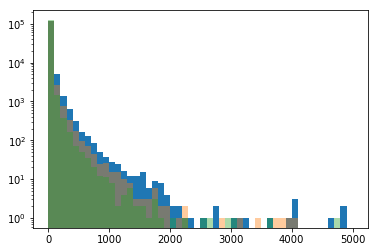

In [50]:
# distribution of number of interactions
plt.hist(rel_df.int_count, log=True, bins=50, range=(0, 5000))
plt.hist(rel_df.initiator_int_count, log=True, bins=50, range=(0, 5000), alpha=0.4)
plt.hist(rel_df.reciprocator_int_count, log=True, bins=50, range=(0, 5000), alpha=0.4)
plt.show()

In [51]:
# no real difference in average number of interactions by initiator
sample1 = rel_df[rel_df.initiator_author_type == 'p'].int_count
sample2 = rel_df[rel_df.initiator_author_type == 'cg'].int_count

np.mean(sample1), \
np.mean(sample2), \
np.mean(sample2) - np.mean(sample1), \
scipy.stats.ttest_ind(sample1, sample2, equal_var=False)

(34.06109625668449,
 34.760406791347066,
 0.6993105346625725,
 Ttest_indResult(statistic=-0.59889851320648, pvalue=0.5492458285396986))

In [52]:
# relationships initiated by caregivers are longer on average
# but this is hard to tease apart without a survival analysis
sample1 = rel_df[rel_df.initiator_author_type == 'p'].duration_months
sample2 = rel_df[rel_df.initiator_author_type == 'cg'].duration_months

np.mean(sample1), \
np.mean(sample2), \
np.mean(sample2) - np.mean(sample1), \
scipy.stats.ttest_ind(sample1, sample2, equal_var=False)

(26.740505215623408,
 27.80766341585772,
 1.0671582002343136,
 Ttest_indResult(statistic=-5.6401478402747305, pvalue=1.712191183660106e-08))

In [53]:
# should probably investigate these relationships with huge numbers of interactions
rel_df[rel_df.int_count > 5000]

,initiator_user_id,reciprocator_user_id,is_reciprocated,int_count,first_int,last_int,initiator_int_count,reciprocator_int_count,int_type_list,created_at_list,initiator_ints_list,duration_months,initiator_author_type,reciprocator_author_type,pct_initiator_ints
169206,5611265,3295808.0,True,5079,1229915767000,1492377712000,5078,1,"[amps, guestbook, guestbook, guestbook, guestb...","[1229915767000, 1256495633000, 1256495633000, ...","[True, True, True, True, True, True, True, Tru...",101.258466,p,cg,0.999803
215561,1939017,3666823.0,True,9676,1244782225000,1544013214000,2875,6801,"[guestbook, guestbook, guestbook, guestbook, g...","[1244782225000, 1244782225000, 1246063413000, ...","[True, True, False, False, False, False, False...",115.444054,p,cg,0.297127
229684,3295808,3241154.0,True,8331,1250131903000,1386103411000,832,7499,"[guestbook, guestbook, guestbook, guestbook, g...","[1250131903000, 1250131903000, 1250131903000, ...","[True, True, True, False, False, False, False,...",52.458144,cg,cg,0.099868
232947,1939017,3295808.0,True,18340,1251259893000,1549782830000,16116,2224,"[guestbook, guestbook, guestbook, guestbook, g...","[1251259893000, 1251259893000, 1251259893000, ...","[True, True, True, True, True, True, False, Fa...",115.170886,p,cg,0.878735
233990,3295808,5485367.0,True,6424,1251587853000,1546217831000,1703,4721,"[guestbook, guestbook, guestbook, guestbook, g...","[1251587853000, 1251600004000, 1251600004000, ...","[True, False, False, False, False, False, Fals...",113.668973,cg,mixed,0.265100


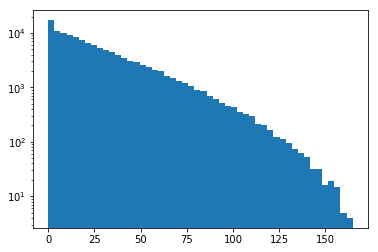

In [54]:
# distribution of relationship distribution
plt.hist(rel_df.duration_months, log=True, bins=50)
plt.show()

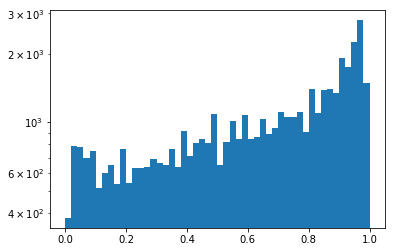

In [55]:
# distribution of relationship "balance"
plt.hist(rel_df[rel_df.int_count >= 20].pct_initiator_ints, log=True, bins=50)
plt.show()

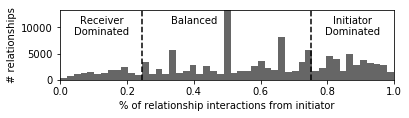

In [56]:
# generate the distribution of the relationship balance as a figure for the paper
fig, ax = plt.subplots(1, 1, figsize=(5.47807, 1.5))
bins = np.linspace(0, 1, num=50)
counts, edges, _ = ax.hist(rel_df.pct_initiator_ints, bins=bins, log=False, color='black', alpha=0.6)
plt.axvline(0.245, color='black', linestyle="--")
plt.axvline(0.751, color='black', linestyle="--")
plt.text(0.4, np.max(counts) * 0.93, 'Balanced', verticalalignment='top', horizontalalignment='center')
plt.text(0.125, np.max(counts) * 0.93, 'Receiver\nDominated', verticalalignment='top', horizontalalignment='center')
plt.text(0.75 + 0.125, np.max(counts) * 0.93, 'Initiator\nDominated', verticalalignment='top', horizontalalignment='center')
ax.set_xlabel("% of relationship interactions from initiator")
ax.set_ylabel("# relationships")

plt.tight_layout(pad=0.2)
plt.margins(0,0)
fig.savefig(fname=os.path.join(figures_dir,"pct_balance_distribution.pdf"), dpi=200, bbox_inches='tight', pad_inches = 0)     
plt.show()

In [57]:
np.sum(rel_df.is_reciprocated) / len(rel_df)

1.0

## Active time features

Computes the total time active on CB

In [58]:
# read in the interactions dataframe
metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
author_to_site = os.path.join(metadata_dir, "interaction_metadata.h5")
ints_df = pd.read_hdf(author_to_site)
len(ints_df)

28388948

In [59]:
# as a quick fix for invalid dates in journals, when created_at is 0 we use the updated_at instead
invalid_created_at = ints_df.created_at <= 0
print(np.sum(invalid_created_at))
ints_df.loc[invalid_created_at, 'created_at'] = ints_df.loc[invalid_created_at, 'updated_at']
print(np.sum(ints_df.created_at <= 0))

44
0


In [60]:
# compute total time on site
# for each user, this is from the very first interaction to the last interaction
s = datetime.now()
total_time_on_site = ints_df[ints_df.user_id.isin(valid_user_ids)].groupby(by='user_id').agg({
    'created_at': np.ptp
}).created_at.rename('total_time_on_site')
total_time_on_site_dict = total_time_on_site.to_dict()
print(datetime.now() - s)
len(total_time_on_site_dict)

0:00:51.396329


362345

In [61]:
# compute first and last recorded update for each user
s = datetime.now()
first_int_time = ints_df[ints_df.user_id.isin(valid_user_ids)].groupby(by='user_id').agg({
    'created_at': np.min
}).created_at
first_int_time_dict = first_int_time.to_dict()
last_int_time = ints_df[ints_df.user_id.isin(valid_user_ids)].groupby(by='user_id').agg({
    'created_at': np.max
}).created_at
last_int_time_dict = last_int_time.to_dict()
print(datetime.now() - s)
len(first_int_time_dict)

0:00:31.252373


362345

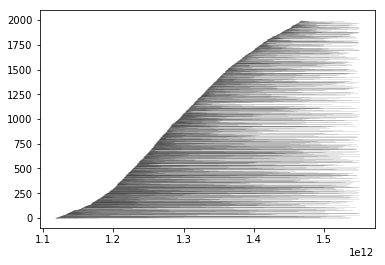

In [62]:
# randomly show some activity timelines, just for fun
tdf = pd.DataFrame(first_int_time)
tdf = tdf.rename(columns={'created_at': 'first_int_time'})
tdf['last_int_time'] = last_int_time
ys = []
xmins = []
xmaxs = []
sample = tdf[tdf.first_int_time > start_timestamp].sample(n=2000)
for i, row in enumerate(sample.sort_values(by='first_int_time', ascending=True).itertuples()):
    xmins.append(row.first_int_time)
    xmaxs.append(row.last_int_time)
    ys.append(i)
plt.hlines(ys, xmins, xmaxs, alpha=0.1, linewidth=1)
plt.show()

In [63]:
# key question: what should the threshold be for "maybe censored?"
# the write for life paper uses 90 days
# so the question becomes: what number of users active in the 90 days
end_of_data_timestamp = np.max(ints_df[ints_df.int_type == 'guestbook'].created_at)
print(datetime.utcfromtimestamp(end_of_data_timestamp / 1000))
threshold_ms = 1000 * 60 * 60 * 24 * 30 * 6 # 6 months
print(datetime.utcfromtimestamp((end_of_data_timestamp - threshold_ms)/ 1000))

2016-06-01 21:07:43
2015-12-04 21:07:43


In [64]:
tdf = pd.DataFrame(first_int_time)
tdf = tdf.rename(columns={'created_at': 'first_int_time'})
tdf['last_int_time'] = last_int_time

In [65]:
# number of valid users that joined CB before the cutoff but posted in the cutoff
# in other words, these are the ACTUALLY censored users
censored_count = np.sum(tdf[tdf.first_int_time <= end_of_data_timestamp - threshold_ms].last_int_time > end_of_data_timestamp - threshold_ms)
censored_count

96376

In [66]:
with tqdm(total=len(last_int_time)) as prog:
    def get_prethreshold_max(created_at):
        prog.update(1)
        prethreshold_idx = created_at <= end_of_data_timestamp - threshold_ms
        if np.sum(prethreshold_idx) == 0:
            return -1
        else:
            return np.max(created_at[prethreshold_idx])
    
    last_int_time_prethreshold = ints_df[
        ints_df.user_id.isin(valid_user_ids)
                                    ].groupby(by='user_id').agg({
        'created_at': get_prethreshold_max
    }).created_at.rename('last_int_time_prethreshold')

100%|██████████| 362345/362345 [05:02<00:00, 1198.65it/s]


In [67]:
assert len(tdf) == len(last_int_time_prethreshold)
tdf['last_int_time_prethreshold'] = last_int_time_prethreshold

In [68]:
no_int_prethreshold = tdf.last_int_time_prethreshold == -1
first_int_postthreshold = tdf.first_int_time >= end_of_data_timestamp - threshold_ms
assert np.all(no_int_prethreshold == first_int_postthreshold)

In [69]:
prethreshold_users = tdf[tdf.first_int_time <= end_of_data_timestamp - threshold_ms]
censored_users = prethreshold_users.last_int_time > end_of_data_timestamp - threshold_ms
considered_censored_users = (prethreshold_users.first_int_time >= end_of_data_timestamp - threshold_ms - threshold_ms)\
|(prethreshold_users.last_int_time_prethreshold >= end_of_data_timestamp - threshold_ms - threshold_ms)
np.sum(censored_users), np.sum(considered_censored_users)

(96376, 67474)

In [70]:
len(prethreshold_users), len(prethreshold_users) / len(tdf)

(347914, 0.9601733154866219)

In [71]:
# recall: what pct of the ACTUALLY censored users are considered to be censored?
# With a 6-month threshold, we miss more than HALF of the users who are censored, concluding that they
# are not in fact censored. (After all, their last update was more than 6 months before the end of data collection)
np.sum(considered_censored_users[censored_users]) / np.sum(censored_users)

0.49538266788412055

In [72]:
# precision: what pct of the considered censored users are actually censored?
np.sum(considered_censored_users[censored_users]) / np.sum(considered_censored_users)

0.7075762515932063

This analysis is immensely depressing, since it suggests we essentially can't tell if a user will post again. (Lots of users who haven't posted for six months will post again!)

What we would like to do is make a claim about the difference between patient-initiated and caregiver-initiated relationships: that they are longer or shorter.


## Regression modeling of interaction count (Poisson)

Note: this requires only the rel_df to be computed.

In [73]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [74]:
rel_df.head(n=1)

,initiator_user_id,reciprocator_user_id,is_reciprocated,int_count,first_int,last_int,initiator_int_count,reciprocator_int_count,int_type_list,created_at_list,initiator_ints_list,duration_months,initiator_author_type,reciprocator_author_type,pct_initiator_ints
9,386,28.0,True,168,1117710956000,1238549181000,34,134,"[guestbook, guestbook, guestbook, guestbook, g...","[1117710956000, 1118835728000, 1119181337000, ...","[True, True, True, True, True, True, True, Tru...",46.619686,mixed,cg,0.202381


In [75]:
rel_df['balance'] = 'balanced'
rel_df.loc[rel_df.pct_initiator_ints >= 0.75, 'balance'] = 'initiator'
rel_df.loc[rel_df.pct_initiator_ints <= 0.25, 'balance'] = 'reciprocator'

In [97]:
rel_df['is_balanced'] = (rel_df.balance == 'balanced').astype(int)
rel_df['is_author_type_shared'] = (rel_df.initiator_author_type == rel_df.reciprocator_author_type).astype(int)

In [98]:
# 52.47\% of relationships are balanced using the indicated thresholds.
np.sum(rel_df.balance == 'balanced') / len(rel_df)

0.5247196109178613

In [99]:
rel_df['pct_initiator_ints_scaled'] = rel_df.pct_initiator_ints * 100

In [100]:
np.quantile(rel_df.int_count, 0.99)

344.0

In [101]:
rel_df_subset = rel_df[rel_df.int_count <= 344]
len(rel_df_subset), len(rel_df_subset) / len(rel_df)

(124377, 0.9900341481664265)

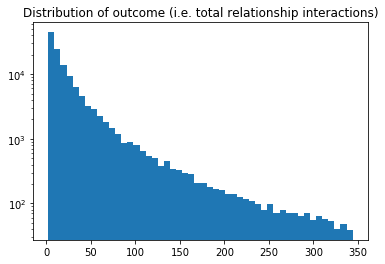

In [102]:
# counts follow a power law, as expected...
# but that makes transformation to normality problematic
plt.hist(rel_df_subset.int_count, bins=50, log=True)
plt.title("Distribution of outcome (i.e. total relationship interactions)")
plt.show()

In [103]:
f = f'int_count ~ C(initiator_author_type) + C(reciprocator_author_type) + pct_initiator_ints_scaled + duration_months'

model = smf.ols(formula=f, data = rel_df_subset)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              int_count   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     2615.
Date:                Mon, 01 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:38:09   Log-Likelihood:            -6.3223e+05
No. Observations:              124377   AIC:                         1.264e+06
Df Residuals:                  124370   BIC:                         1.265e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                6.3095      0.313     20.178      0.000       5.697       6.922
C(initiator_author_type)[T.mixed]       -0.7199      0.409     -1.761      0.078      -1.521       0.081
C(initiator_author_type)[T.p]           -0.8956      0.305     -2.936      0.003      -1.494      -0.298
C(reciprocator_author_type)[T.mixed]    -1.0798      0.409     -2.640      0.008      -1.881      -0.278
C(reciprocator_author_type)[T.p]        -0.5148      0.318     -1.618      0.106      -1.138       0.109
pct_initiator_ints_scaled                0.1337      0.004     30.826      0.000       0.125       0.142
duration_months                          0.5294      0.004    122.052      0.000       0.521       0.538
==============================================================================
Omnibus:                    89708.105   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1525069.398
Skew:                           3.373   Prob(JB):                         0.00
Kurtosis:                      18.772   Cond. No.                         272.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
# ANOVA for an interaction
# this is significant
import statsmodels.stats
md0 = smf.ols('int_count ~ C(initiator_author_type) + C(reciprocator_author_type)', data=rel_df_subset).fit()
md1 = smf.ols('int_count ~ C(initiator_author_type) + C(reciprocator_author_type) + duration_months', data=rel_df_subset).fit()
md2 = smf.ols('int_count ~ C(initiator_author_type) * C(reciprocator_author_type) + duration_months', data=rel_df_subset).fit()

anovaResults = statsmodels.stats.anova.anova_lm(md0, md1, md2, typ=1)
print(anovaResults)

   df_resid           ssr  df_diff       ss_diff             F        Pr(>F)
0  124372.0  2.132198e+08      0.0           NaN           NaN           NaN
1  124371.0  1.908747e+08      1.0  2.234506e+07  14569.673705  0.000000e+00
2  124367.0  1.907379e+08      4.0  1.368236e+05     22.303309  1.964537e-18


/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [105]:
f = f'np.log(int_count) ~ C(initiator_author_type) * C(reciprocator_author_type) + pct_initiator_ints_scaled + duration_months'

model = smf.ols(formula=f, data = rel_df_subset)
res = model.fit()

log_linear_preds = res.predict(rel_df_subset)

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(int_count)   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     2686.
Date:                Mon, 01 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:38:14   Log-Likelihood:            -1.8073e+05
No. Observations:              124377   AIC:                         3.615e+05
Df Residuals:                  124366   BIC:                         3.616e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  1.8398      0.008    220.691      0.000       1.823       1.856
C(initiator_author_type)[T.mixed]                                         -0.0119      0.013     -0.910      0.363      -0.037       0.014
C(initiator_author_type)[T.p]                                             -0.0720      0.010     -6.942      0.000      -0.092      -0.052
C(reciprocator_author_type)[T.mixed]                                      -0.0305      0.013     -2.274      0.023      -0.057      -0.004
C(reciprocator_author_type)[T.p]                                          -0.0181      0.011     -1.611      0.107      -0.040       0.004
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.mixed]     0.0663      0.034      1.933      0.053      -0.001       0.133
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.mixed]         0.1845      0.027      6.952      0.000       0.132       0.236
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.p]         0.1150      0.028      4.100      0.000       0.060       0.170
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.p]             0.2617      0.019     14.008      0.000       0.225       0.298
pct_initiator_ints_scaled                                                  0.0055      0.000     47.410      0.000       0.005       0.006
duration_months                                                            0.0182      0.000    157.787      0.000       0.018       0.018
==============================================================================
Omnibus:                     1442.471   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1427.817
Skew:                           0.243   Prob(JB):                    8.99e-311
Kurtosis:                       2.801   Cond. No.                         870.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
np.exp(res.params)

Intercept                                                                 6.295523
C(initiator_author_type)[T.mixed]                                         0.988192
C(initiator_author_type)[T.p]                                             0.930570
C(reciprocator_author_type)[T.mixed]                                      0.969966
C(reciprocator_author_type)[T.p]                                          0.982047
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.mixed]    1.068526
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.mixed]        1.202597
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.p]        1.121924
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.p]            1.299080
pct_initiator_ints_scaled                                                 1.005468
duration_months                                                           1.018318
dtype: float64

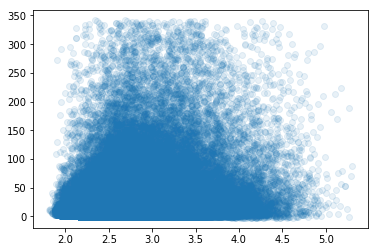

In [107]:
resid = rel_df_subset.int_count - log_linear_preds
plt.scatter(log_linear_preds, resid, alpha=0.1)
plt.show()

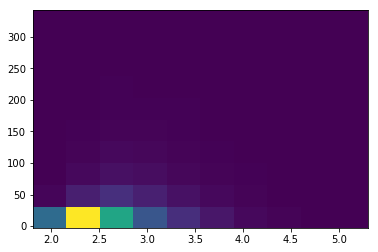

In [108]:
resid = rel_df_subset.int_count - log_linear_preds
plt.hist2d(log_linear_preds, resid)
plt.show()

In [109]:
f = f'int_count ~ C(initiator_author_type) * C(reciprocator_author_type) + pct_initiator_ints_scaled + duration_months'

model = smf.ols(formula=f, data = rel_df_subset)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              int_count   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     1579.
Date:                Mon, 01 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:38:17   Log-Likelihood:            -6.3218e+05
No. Observations:              124377   AIC:                         1.264e+06
Df Residuals:                  124366   BIC:                         1.264e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  6.5929      0.314     20.977      0.000       5.977       7.209
C(initiator_author_type)[T.mixed]                                         -1.2218      0.492     -2.482      0.013      -2.187      -0.257
C(initiator_author_type)[T.p]                                             -3.1749      0.391     -8.124      0.000      -3.941      -2.409
C(reciprocator_author_type)[T.mixed]                                      -2.2357      0.506     -4.422      0.000      -3.227      -1.245
C(reciprocator_author_type)[T.p]                                          -2.7577      0.424     -6.506      0.000      -3.589      -1.927
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.mixed]     2.0303      1.293      1.570      0.116      -0.504       4.564
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.mixed]         4.9590      1.000      4.957      0.000       2.998       6.920
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.p]         2.6315      1.058      2.487      0.013       0.558       4.705
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.p]             6.3767      0.704      9.055      0.000       4.996       7.757
pct_initiator_ints_scaled                                                  0.1339      0.004     30.872      0.000       0.125       0.142
duration_months                                                            0.5302      0.004    122.252      0.000       0.522       0.539
==============================================================================
Omnibus:                    89741.507   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1527738.078
Skew:                           3.375   Prob(JB):                         0.00
Kurtosis:                      18.787   Cond. No.                         870.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

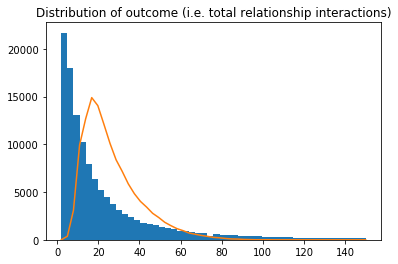

array([    5,   371,  3093,  9903, 12662, 14884, 14048, 12097, 10098,
        8377,  7174,  5863,  4831,  4020,  3433,  2776,  2336,  1831,
        1482,  1169,   958,   710,   582,   457,   362,   255,   212,
         140,    88,    76,    38,    24,     6,     9,     7,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [110]:
# linear model fit to the data, consistently overestimates
linear_preds = res.predict(rel_df_subset)
_, bins, _ = plt.hist(rel_df_subset.int_count, bins=50, log=False, range=(2, 150))
plt.title("Distribution of outcome (i.e. total relationship interactions)")
pred_density, _ = np.histogram(linear_preds, bins=bins)
#bins = np.linspace(2, 300, num=300)
#pred_density, _ = np.histogram(preds, bins=bins)
plt.plot(bins, pred_density.tolist() + [0,])
plt.show()
pred_density

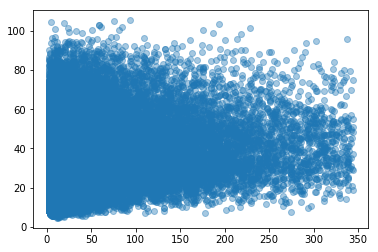

In [111]:
plt.scatter(rel_df_subset.int_count, linear_preds, alpha=0.4)
plt.show()

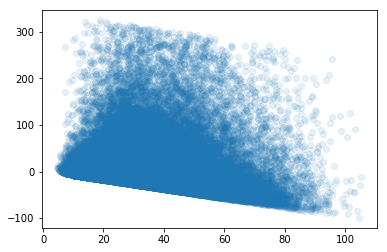

In [112]:
resid = rel_df_subset.int_count - linear_preds
plt.scatter(linear_preds, resid, alpha=0.1)
plt.show()

In [113]:
#for line in res.summary2().as_latex().split("\n"):
#    line = line.replace("\_", "-").replace("_", "-")
#    print(line)

In [114]:
f = f'int_count ~ is_author_type_shared + pct_initiator_ints_scaled + duration_months'
#rel_df_subset.loc[:, 'is_author_type_shared'] = (rel_df_subset.initiator_author_type == rel_df_subset.reciprocator_author_type).astype(int)
model = smf.ols(formula=f, data = rel_df_subset)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              int_count   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     5257.
Date:                Mon, 01 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:38:22   Log-Likelihood:            -6.3219e+05
No. Observations:              124377   AIC:                         1.264e+06
Df Residuals:                  124373   BIC:                         1.264e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.3068      0.343     12.567      0.000       3.635       4.979
is_author_type_shared         2.3216      0.239      9.731      0.000       1.854       2.789
pct_initiator_ints_scaled     0.1338      0.004     30.862      0.000       0.125       0.142
duration_months               0.5298      0.004    122.244      0.000       0.521       0.538
==============================================================================
Omnibus:                    89725.537   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1526634.746
Skew:                           3.374   Prob(JB):                         0.00
Kurtosis:                      18.781   Cond. No.                         229.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Actually doing Poisson regression

In [115]:
f = f'int_count ~ C(initiator_author_type) * C(reciprocator_author_type) + pct_initiator_ints_scaled + duration_months'

model = smf.poisson(formula=f, data = rel_df_subset)
res = model.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 17.920771
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:              int_count   No. Observations:               124377
Model:                        Poisson   Df Residuals:                   124366
Method:                           MLE   Df Model:                           10
Date:                Mon, 01 Jun 2020   Pseudo R-squ.:                  0.1394
Time:                        15:38:29   Log-Likelihood:            -2.2289e+06
converged:                       True   LL-Null:                   -2.5899e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================================================================
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  2.6087      0.002   1650.479      0.000       2.606       2.612
C(initiator_author_type)[T.mixed]                                         -0.0481      0.002    -19.765      0.000      -0.053      -0.043
C(initiator_author_type)[T.p]                                             -0.1103      0.002    -56.589      0.000      -0.114      -0.106
C(reciprocator_author_type)[T.mixed]                                      -0.0777      0.002    -31.142      0.000      -0.083      -0.073
C(reciprocator_author_type)[T.p]                                          -0.0956      0.002    -44.911      0.000      -0.100      -0.091
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.mixed]     0.0657      0.006     10.177      0.000       0.053       0.078
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.mixed]         0.1748      0.005     35.753      0.000       0.165       0.184
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.p]         0.1051      0.005     19.857      0.000       0.095       0.115
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.p]             0.2266      0.003     64.744      0.000       0.220       0.233
pct_initiator_ints_scaled                                                  0.0046   2.07e-05    221.167      0.000       0.005       0.005
duration_months                                                            0.0146   1.64e-05    887.987      0.000       0.015       0.015
==========================================================================================================================================
"""

In [116]:
np.exp(res.params)

Intercept                                                                 13.581607
C(initiator_author_type)[T.mixed]                                          0.953046
C(initiator_author_type)[T.p]                                              0.895556
C(reciprocator_author_type)[T.mixed]                                       0.925256
C(reciprocator_author_type)[T.p]                                           0.908806
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.mixed]     1.067919
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.mixed]         1.190989
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.p]         1.110815
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.p]             1.254331
pct_initiator_ints_scaled                                                  1.004583
duration_months                                                            1.014670
dtype: float64

In [117]:
# dispersion is assumed to be 1 by poisson regression
res.scale

1.0

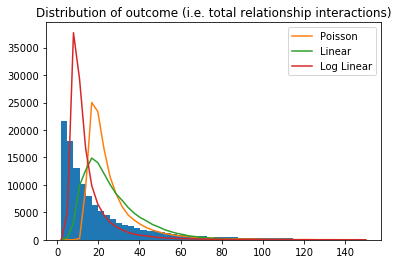

array([    0,     0,     0,   219,  9458, 25013, 23353, 16650, 11520,
        8375,  6034,  4496,  3570,  2807,  2227,  1764,  1449,  1135,
         959,   763,   653,   587,   422,   419,   322,   269,   227,
         214,   160,   193,   125,   136,   109,    86,    84,    75,
          69,    67,    41,    26,    49,    39,    17,    24,    25,
          20,    20,    14,    12,    11])

In [118]:
# the poisson model consistently overestimates the counts
_, bins, _ = plt.hist(rel_df_subset.int_count, bins=50, log=False, range=(2, 150))
plt.title("Distribution of outcome (i.e. total relationship interactions)")
poisson_preds = res.predict(rel_df_subset)
pred_density, _ = np.histogram(poisson_preds, bins=bins)
#bins = np.linspace(2, 300, num=300)
#pred_density, _ = np.histogram(preds, bins=bins)
plt.plot(bins, pred_density.tolist() + [0,], label='Poisson')

#
linear_pred_density, _ = np.histogram(linear_preds, bins=bins)
plt.plot(bins, linear_pred_density.tolist() + [0,], label='Linear')

log_linear_pred_density, _ = np.histogram(np.exp(log_linear_preds), bins=bins)
plt.plot(bins, log_linear_pred_density.tolist() + [0,], label='Log Linear')


plt.legend()

plt.show()
pred_density

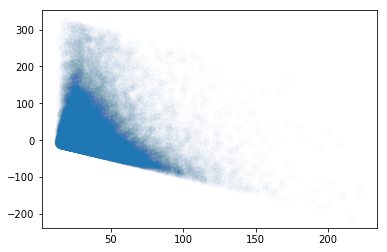

In [121]:
resid = rel_df_subset.int_count - poisson_preds
plt.scatter(poisson_preds, resid, alpha=0.01)
plt.show()

In [122]:
f = f'int_count_beyond_initial ~ C(initiator_author_type) * C(reciprocator_author_type) + pct_initiator_ints_scaled + duration_months'
rel_df_subset['int_count_beyond_initial'] = rel_df_subset.int_count - 2
model = smf.poisson(formula=f, data = rel_df_subset)
res = model.fit()
res.summary()

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Optimization terminated successfully.
         Current function value: 19.164120
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Poisson Regression Results                             
====================================================================================
Dep. Variable:     int_count_beyond_initial   No. Observations:               124377
Model:                              Poisson   Df Residuals:                   124366
Method:                                 MLE   Df Model:                           10
Date:                      Mon, 01 Jun 2020   Pseudo R-squ.:                  0.1389
Time:                              15:38:59   Log-Likelihood:            -2.3836e+06
converged:                             True   LL-Null:                   -2.7681e+06
Covariance Type:                  nonrobust   LLR p-value:                     0.000
==========================================================================================================================================
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  2.4810      0.002   1507.440      0.000       2.478       2.484
C(initiator_author_type)[T.mixed]                                         -0.0521      0.003    -20.604      0.000      -0.057      -0.047
C(initiator_author_type)[T.p]                                             -0.1185      0.002    -58.457      0.000      -0.123      -0.115
C(reciprocator_author_type)[T.mixed]                                      -0.0835      0.003    -32.199      0.000      -0.089      -0.078
C(reciprocator_author_type)[T.p]                                          -0.1028      0.002    -46.381      0.000      -0.107      -0.098
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.mixed]     0.0702      0.007     10.448      0.000       0.057       0.083
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.mixed]         0.1881      0.005     37.045      0.000       0.178       0.198
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.p]         0.1140      0.006     20.712      0.000       0.103       0.125
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.p]             0.2439      0.004     67.023      0.000       0.237       0.251
pct_initiator_ints_scaled                                                  0.0049   2.14e-05    228.980      0.000       0.005       0.005
duration_months                                                            0.0154   1.68e-05    919.511      0.000       0.015       0.015
==========================================================================================================================================
"""

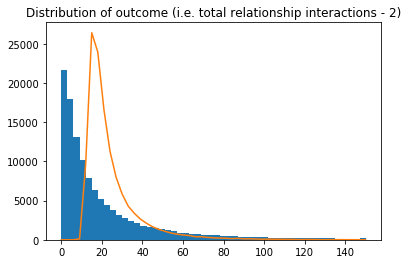

array([    0,     0,     0,   124,  9556, 26444, 23959, 16652, 11307,
        7999,  5828,  4295,  3375,  2641,  2106,  1662,  1335,  1097,
         876,   720,   615,   549,   398,   394,   307,   255,   219,
         209,   152,   189,   121,   130,   103,    78,    90,    69,
          70,    56,    57,    27,    42,    41,    30,    14,    23,
          22,    19,    17,    13,    11])

In [123]:
# the poisson model consistently overestimates the counts
preds = res.predict(rel_df_subset)
_, bins, _ = plt.hist(rel_df_subset.int_count_beyond_initial, bins=50, log=False, range=(0, 150))
plt.title("Distribution of outcome (i.e. total relationship interactions - 2)")
pred_density, _ = np.histogram(preds, bins=bins)
#bins = np.linspace(2, 300, num=300)
#pred_density, _ = np.histogram(preds, bins=bins)
plt.plot(bins, pred_density.tolist() + [0,])
plt.show()
pred_density

In [124]:
# negative binomial model
f = f'int_count ~ C(initiator_author_type) * C(reciprocator_author_type) + is_balanced + duration_months'

model = smf.negativebinomial(formula=f, data = rel_df_subset)
res = model.fit(maxiter=100)
res.summary()

Optimization terminated successfully.
         Current function value: 4.225144
         Iterations: 48
         Function evaluations: 55
         Gradient evaluations: 55


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:              int_count   No. Observations:               124377
Model:               NegativeBinomial   Df Residuals:                   124366
Method:                           MLE   Df Model:                           10
Date:                Mon, 01 Jun 2020   Pseudo R-squ.:                 0.02746
Time:                        15:39:11   Log-Likelihood:            -5.2551e+05
converged:                       True   LL-Null:                   -5.4035e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================================================================
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  2.8610      0.006    471.768      0.000       2.849       2.873
C(initiator_author_type)[T.mixed]                                         -0.0194      0.012     -1.553      0.120      -0.044       0.005
C(initiator_author_type)[T.p]                                             -0.0748      0.010     -7.533      0.000      -0.094      -0.055
C(reciprocator_author_type)[T.mixed]                                      -0.0338      0.013     -2.632      0.008      -0.059      -0.009
C(reciprocator_author_type)[T.p]                                          -0.0553      0.011     -5.138      0.000      -0.076      -0.034
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.mixed]     0.0430      0.033      1.311      0.190      -0.021       0.107
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.mixed]         0.1717      0.025      6.768      0.000       0.122       0.221
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.p]         0.0798      0.027      2.972      0.003       0.027       0.132
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.p]             0.2321      0.018     12.984      0.000       0.197       0.267
is_balanced                                                               -0.3545      0.006    -63.027      0.000      -0.366      -0.343
duration_months                                                            0.0198      0.000    150.527      0.000       0.020       0.020
alpha                                                                      0.9337      0.004    265.084      0.000       0.927       0.941
==========================================================================================================================================
"""

In [125]:
# these are the incidence rate ratios
np.exp(res.params)

Intercept                                                                 17.478837
C(initiator_author_type)[T.mixed]                                          0.980780
C(initiator_author_type)[T.p]                                              0.927963
C(reciprocator_author_type)[T.mixed]                                       0.966797
C(reciprocator_author_type)[T.p]                                           0.946164
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.mixed]     1.043970
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.mixed]         1.187271
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.p]         1.083074
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.p]             1.261271
is_balanced                                                                0.701511
duration_months                                                            1.019982
alpha                                                                      2

In [126]:
# initiating patient
1 - np.exp(-0.074763)

0.07203661240791681

In [127]:
# receiver patient
1 - np.exp(-0.055339)

0.05383565613230756

In [128]:
# initiating and receiving patient
np.exp(-0.074763 -0.055339 + 0.232120) - 1

0.10740340480982158

In [129]:
for line in res.summary2().as_latex().split("\n")[17:13+25]:
    line = line.replace("\_", "-").replace("_", "-")
    line = re.sub('\s+', ' ', line).strip()
    print(line)

\begin{tabular}{lcccccc}
\hline
& Coef. & Std.Err. & z & P$> |$z$|$ & [0.025 & 0.975] \\
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
Intercept & 2.8610 & 0.0061 & 471.7680 & 0.0000 & 2.8491 & 2.8729 \\
C(initiator-author-type)[T.mixed] & -0.0194 & 0.0125 & -1.5531 & 0.1204 & -0.0439 & 0.0051 \\
C(initiator-author-type)[T.p] & -0.0748 & 0.0099 & -7.5329 & 0.0000 & -0.0942 & -0.0553 \\
C(reciprocator-author-type)[T.mixed] & -0.0338 & 0.0128 & -2.6322 & 0.0085 & -0.0589 & -0.0086 \\
C(reciprocator-author-type)[T.p] & -0.0553 & 0.0108 & -5.1382 & 0.0000 & -0.0764 & -0.0342 \\
C(initiator-author-type)[T.mixed]:C(reciprocator-author-type)[T.mixed] & 0.0430 & 0.0328 & 1.3112 & 0.1898 & -0.0213 & 0.1074 \\
C(initiator-author-type)[T.p]:C(reciprocator-author-type)[T.mixed] & 0.1717 & 0.0254 & 6.7680 & 0.0000 & 0.1219 & 0.2214 \\
C(initiator-author-type)[T.mixed]:C(reciprocator-author-type)[T.p] & 0.0798 & 0.0268 & 2.9724 & 0.0030 & 0.0272 & 0.1324 \\
C(initiator-author-type)[T.p]:C(rec

[Predicted counts](https://stats.stackexchange.com/questions/17006/interpretation-of-incidence-rate-ratios) for 6-month, perfectly balanced relationships.

Computed with a slightly older version of the model that used a different balance control var, but the same approach works for computing predicted counts at a particular number of months.

```
# p init, p receiver
>>> np.exp(2.4489 + 0.0038 * 50 + 0.0203 * 6 - 0.0688 * 1 - 0.0372 * 1 + 0.1894 * 1)
17.18608423066515
# p init, cg receiver
>>> np.exp(2.4489 + 0.0038 * 50 + 0.0203 * 6 - 0.0688 * 1 - 0.0372 * 0 + 0.1894 * 0)
14.75969271221521
# cg init, p receiver
>>> np.exp(2.4489 + 0.0038 * 50 + 0.0203 * 6 - 0.0688 * 0 - 0.0372 * 1 + 0.1894 * 0)
15.23354646085602
# cg init, cg receiver
>>> np.exp(2.4489 + 0.0038 * 50 + 0.0203 * 6 - 0.0688 * 0 - 0.0372 * 0 + 0.1894 * 0)
15.810906710189084
```

In [130]:
nb_preds = res.predict(rel_df_subset)

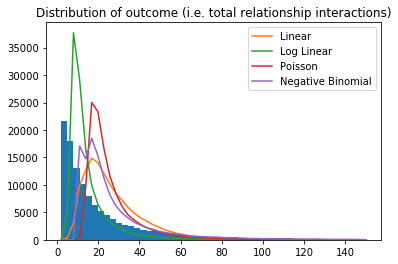

array([    0,     0,     0,   124,  9556, 26444, 23959, 16652, 11307,
        7999,  5828,  4295,  3375,  2641,  2106,  1662,  1335,  1097,
         876,   720,   615,   549,   398,   394,   307,   255,   219,
         209,   152,   189,   121,   130,   103,    78,    90,    69,
          70,    56,    57,    27,    42,    41,    30,    14,    23,
          22,    19,    17,    13,    11])

In [131]:
# of the four models tried, it looks like the negative binomial model is the best fit
# although, 
_, bins, _ = plt.hist(rel_df_subset.int_count, bins=50, log=False, range=(2, 150))
plt.title("Distribution of outcome (i.e. total relationship interactions)")

linear_pred_density, _ = np.histogram(linear_preds, bins=bins)
plt.plot(bins, linear_pred_density.tolist() + [0,], label='Linear')

log_linear_pred_density, _ = np.histogram(np.exp(log_linear_preds), bins=bins)
plt.plot(bins, log_linear_pred_density.tolist() + [0,], label='Log Linear')

poisson_pred_density, _ = np.histogram(poisson_preds, bins=bins)
plt.plot(bins, poisson_pred_density.tolist() + [0,], label='Poisson')

nb_pred_density, _ = np.histogram(nb_preds, bins=bins)
plt.plot(bins, nb_pred_density.tolist() + [0,], label='Negative Binomial')

plt.legend()

plt.show()
pred_density

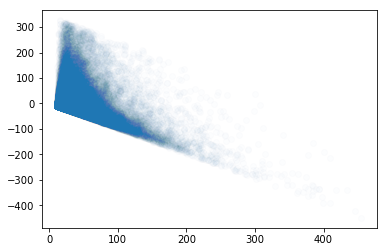

In [132]:
resid = rel_df_subset.int_count - nb_preds
plt.scatter(nb_preds, resid, alpha=0.01)
plt.show()

In [133]:
for line in res.summary2().as_latex().split("\n"):
    line = line.replace("\_", "-").replace("_", "-")
    print(line)

\begin{table}
\caption{Results: NegativeBinomial}
\begin{center}
\begin{tabular}{llll}
\hline
Model:              & NegativeBinomial & Pseudo R-squared: & 0.027         \\
Dependent Variable: & int-count       & AIC:              & 1051045.3724  \\
Date:               & 2020-06-01 15:39 & BIC:              & 1051162.1452  \\
No. Observations:   & 124377           & Log-Likelihood:   & -5.2551e+05   \\
Df Model:           & 10               & LL-Null:          & -5.4035e+05   \\
Df Residuals:       & 124366           & LLR p-value:      & 0.0000        \\
Converged:          & 1.0000           & Scale:            & 1.0000        \\
\hline
\end{tabular}
\end{center}
\hline
\begin{center}
\begin{tabular}{lcccccc}
\hline
                                                                           &  Coef.  & Std.Err. &    z     & P$> |$z$|$ &  [0.025 &  0.975]  \\
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
Intercept                                                                  &

## Relationship "balance" analysis

In [134]:
rel_df['balance'] = 'balanced'
rel_df.loc[rel_df.pct_initiator_ints >= 0.75, 'balance'] = 'initiator'
rel_df.loc[rel_df.pct_initiator_ints <= 0.25, 'balance'] = 'reciprocator'

In [135]:
for rel_type, count in Counter(rel_df.balance).most_common():
    print(f"{rel_type:>20} {count} {count / len(rel_df) * 100:.2f}%")

            balanced 65920 52.47%
           initiator 41231 32.82%
        reciprocator 18478 14.71%


In [136]:
np.sum(rel_df[rel_df.int_count > 10].pct_initiator_ints > 0.5) / len(rel_df[rel_df.int_count > 10])

0.6311039174805223

In [137]:
for initiator in ['p', 'cg']:
    for reciprocator in ['p', 'cg']:
        rel_df_subset = rel_df[(rel_df.initiator_author_type == initiator)&(rel_df.reciprocator_author_type == reciprocator)]
        print(initiator, reciprocator)
        for rel_type, count in Counter(rel_df_subset.balance).most_common():
            print(f"{rel_type:>20} {count} {count / len(rel_df_subset) * 100:.2f}%")

p p
            balanced 4661 55.88%
           initiator 2507 30.06%
        reciprocator 1173 14.06%
p cg
            balanced 5838 50.36%
           initiator 3970 34.25%
        reciprocator 1784 15.39%
cg p
            balanced 4863 50.65%
           initiator 3204 33.37%
        reciprocator 1535 15.99%
cg cg
            balanced 40714 53.08%
           initiator 24923 32.49%
        reciprocator 11073 14.43%


In [138]:
# when initiator and receiver share an author type, relationship is more likely to be balanced
sample1 = (rel_df[rel_df.initiator_author_type == rel_df.reciprocator_author_type].balance == 'balanced').astype(int)
sample2 = (rel_df[rel_df.initiator_author_type != rel_df.reciprocator_author_type].balance == 'balanced').astype(int)

np.mean(sample1), \
np.mean(sample2), \
np.mean(sample1) - np.mean(sample2), \
scipy.stats.ttest_ind(sample1, sample2, equal_var=False)

(0.5334622868791697,
 0.5055098872572723,
 0.02795239962189744,
 Ttest_indResult(statistic=9.193389591327932, pvalue=3.8992763978937396e-20))

In [139]:
rel_df['is_balanced'] = (rel_df.balance == 'balanced').astype(int)

In [140]:
def print_feature_summary(res):
    for feature, coef in zip(res.params.index, res.params):
        prob = np.exp(coef)/(1+np.exp(coef))
        feature_name = feature.replace("_author_type", "_AR")
        if "health_condition" in feature_name:
            feature_name = "health_condition " + feature_name.split("[")[1][2:-1]
        print(f"{feature_name:<50} {min((np.exp(coef)-1)*100, 999):>8.3f}% increase   {prob*100:>8.2f}%   ({np.exp(coef):.3f})")

In [141]:
formula = """
is_balanced ~  
    C(initiator_author_type) * C(reciprocator_author_type)
    + int_count
    + duration_months
    + 1
"""
model = smf.logit(formula=formula, 
                  data=rel_df)
res = model.fit(maxiter=100)
print_feature_summary(res)
res.summary()

Optimization terminated successfully.
         Current function value: 0.682556
         Iterations 6
Intercept                                            47.217% increase      59.55%   (1.472)
C(initiator_AR)[T.mixed]                             -8.968% increase      47.65%   (0.910)
C(initiator_AR)[T.p]                                -10.843% increase      47.13%   (0.892)
C(reciprocator_AR)[T.mixed]                         -12.620% increase      46.63%   (0.874)
C(reciprocator_AR)[T.p]                             -11.041% increase      47.08%   (0.890)
C(initiator_AR)[T.mixed]:C(reciprocator_AR)[T.mixed]   22.383% increase      55.03%   (1.224)
C(initiator_AR)[T.p]:C(reciprocator_AR)[T.mixed]     12.588% increase      52.96%   (1.126)
C(initiator_AR)[T.mixed]:C(reciprocator_AR)[T.p]     13.950% increase      53.26%   (1.140)
C(initiator_AR)[T.p]:C(reciprocator_AR)[T.p]         37.102% increase      57.82%   (1.371)
int_count                                            -0.285% increas

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_balanced   No. Observations:               125629
Model:                          Logit   Df Residuals:                   125618
Method:                           MLE   Df Model:                           10
Date:                Mon, 01 Jun 2020   Pseudo R-squ.:                 0.01354
Time:                        15:39:57   Log-Likelihood:                -85749.
converged:                       True   LL-Null:                       -86926.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================================================================
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  0.3867      0.010     39.788      0.000       0.368       0.406
C(initiator_author_type)[T.mixed]                                         -0.0940      0.025     -3.713      0.000      -0.144      -0.044
C(initiator_author_type)[T.p]                                             -0.1148      0.020     -5.707      0.000      -0.154      -0.075
C(reciprocator_author_type)[T.mixed]                                      -0.1349      0.026     -5.184      0.000      -0.186      -0.084
C(reciprocator_author_type)[T.p]                                          -0.1170      0.022     -5.363      0.000      -0.160      -0.074
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.mixed]     0.2020      0.067      3.032      0.002       0.071       0.333
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.mixed]         0.1186      0.051      2.304      0.021       0.018       0.219
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.p]         0.1306      0.054      2.400      0.016       0.024       0.237
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.p]             0.3156      0.036      8.685      0.000       0.244       0.387
int_count                                                                 -0.0029      0.000    -26.001      0.000      -0.003      -0.003
duration_months                                                           -0.0060      0.000    -25.699      0.000      -0.006      -0.006
==========================================================================================================================================
"""

In [142]:
for line in res.summary2().as_latex().split("\n"):
    line = line.replace("\_", "-").replace("_", "-")
    print(line)

\begin{table}
\caption{Results: Logit}
\begin{center}
\begin{tabular}{llll}
\hline
Model:              & Logit            & Pseudo R-squared: & 0.014        \\
Dependent Variable: & is-balanced     & AIC:              & 171519.6943  \\
Date:               & 2020-06-01 15:39 & BIC:              & 171626.8463  \\
No. Observations:   & 125629           & Log-Likelihood:   & -85749.      \\
Df Model:           & 10               & LL-Null:          & -86926.      \\
Df Residuals:       & 125618           & LLR p-value:      & 0.0000       \\
Converged:          & 1.0000           & Scale:            & 1.0000       \\
No. Iterations:     & 6.0000           &                   &              \\
\hline
\end{tabular}
\end{center}
\hline
\begin{center}
\begin{tabular}{lcccccc}
\hline
                                                                           &  Coef.  & Std.Err. &    z     & P$> |$z$|$ &  [0.025 &  0.975]  \\
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
Intercept        

In [143]:
formula = """
is_balanced ~  
    is_author_type_shared
    + int_count
    + duration_months
    + 1
"""
model = smf.logit(formula=formula, 
                  data=rel_df)
res = model.fit(maxiter=100)
print_feature_summary(res)
res.summary()

Optimization terminated successfully.
         Current function value: 0.682618
         Iterations 6
Intercept                                            31.431% increase      56.79%   (1.314)
is_AR_shared                                         12.959% increase      53.04%   (1.130)
int_count                                            -0.285% increase      49.93%   (0.997)
duration_months                                      -0.603% increase      49.85%   (0.994)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_balanced   No. Observations:               125629
Model:                          Logit   Df Residuals:                   125625
Method:                           MLE   Df Model:                            3
Date:                Mon, 01 Jun 2020   Pseudo R-squ.:                 0.01345
Time:                        15:39:57   Log-Likelihood:                -85757.
converged:                       True   LL-Null:                       -86926.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.2733      0.012     22.967      0.000       0.250       0.297
is_author_type_shared     0.1219      0.012      9.919      0.000       0.098       0.146
int_count                -0.0028      0.000    -26.007      0.000      -0.003      -0.003
duration_months          -0.0060      0.000    -25.833      0.000      -0.007      -0.006
=========================================================================================
"""

In [144]:
# 68\% of relationships are between authors with a shared role
len(rel_df[rel_df.initiator_author_type == rel_df.reciprocator_author_type]) / len(rel_df)

0.687229859347762

## Survival analysis


In [71]:
import lifelines

In [93]:
subset_df = rel_df[rel_df.int_count >= 10]
subset_df = pd.get_dummies(subset_df, columns=['initiator_author_type', 'reciprocator_author_type'])
subset_df = subset_df[['duration_months', 
                       'initiator_author_type_p', 'initiator_author_type_mixed',
                       'reciprocator_author_type_p', 'reciprocator_author_type_mixed',
                       'int_count', 'pct_initiator_ints'
                      ]]
print(subset_df.shape)
subset_df.head()

(76918, 7)


,duration_months,initiator_author_type_p,initiator_author_type_mixed,reciprocator_author_type_p,reciprocator_author_type_mixed,int_count,pct_initiator_ints
9,46.619686,0,1,0,0,168,0.202381
15,83.597437,0,0,0,0,63,0.269841
16,3.664537,0,0,0,0,24,0.375000
18,63.155752,0,0,0,0,13,0.769231
23,43.833507,0,0,0,0,21,0.190476


In [94]:
cph = lifelines.CoxPHFitter()
cph.fit(subset_df, duration_col='duration_months')

<lifelines.CoxPHFitter: fitted with 76918 total observations, 0 right-censored observations>

In [95]:
cph.print_summary()

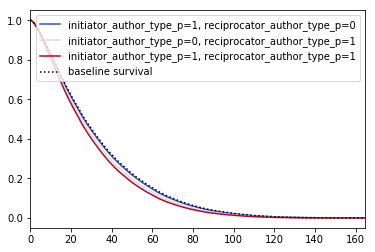

In [96]:
cph.plot_covariate_groups(
    ['initiator_author_type_p', 'reciprocator_author_type_p'],
    [[1, 0], [0, 1], [1, 1]],
    cmap='coolwarm'
)

In [97]:
cph.check_assumptions(subset_df)

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'initiator_author_type_p' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['initiator_author_type_p',
...]` in the call in `.fit`. See documentation in link [E] below.

2. Variable 'initiator_author_type_mixed' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include
`strata=['initiator_author_type_mixed', ...]` in the call in `.fit`. See documentation in link [E]
below.

3. Variable 'int_count' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'int_count' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'int_count' using pd.cut, and then specify it in
`strata=['int_count', .

## Reciprocations by type

Response: Does a reciprocation happen within 1 year?

Feature: Time between target's first update and the dyad initiation
Feature: Time between initiator's first update and the dyad initiation
Feature: Target author role
Feature: Initiator author role
Feature: Shared author role
Feature: Shared health condition

Thought: This actually seems like it's almost the same as the mlogit stuff

In [17]:
u2u_df.head()

,from_user_id,to_user_id,created_at,int_type
0,1,196238,1141566915000,guestbook
1,2,269744,1146502838000,guestbook
2,2,76800,1141824958000,guestbook
3,2,76800,1141826075000,guestbook
4,2,76800,1144118979000,guestbook


In [ ]:
def get_features(group):
    

dyad_recips = u2u_df.sort_values(by='created_at', ascending=True).groupby(by=['from_user_id', 'to_user_id']).apply(get_features)

## Other Features

In [16]:
user_df['is_multisite_author'] = user_df.num_sites > 1
np.sum(user_df.is_multisite_author) / len(user_df)

0.05158343567594419

In [17]:
is_mixedsite_author_dict = {}
site_author_sets = journal_df[journal_df.user_id.isin(valid_user_ids)].groupby('site_id').agg({'user_id': lambda user_ids: set(user_ids)})
for site_id, user_ids in zip(site_author_sets.index, site_author_sets.user_id):
    if len(user_ids) > 1:
        for user_id in user_ids:
            is_mixedsite_author_dict[user_id] = True
is_mixedsite_author = [user_id in is_mixedsite_author_dict for user_id in user_df.user_id]
user_df['is_mixedsite_author'] = is_mixedsite_author
# 21.8% of authors have written updates on a site on which another valid author has written an update 
np.sum(is_mixedsite_author), np.sum(is_mixedsite_author) / len(is_mixedsite_author)

(79115, 0.2183416357339)

In [18]:
# merge in the health condition data
user_health_cond_dict = {user_id: assigned_health_cond for user_id, assigned_health_cond in zip(user_health_conds_df.user_id, user_health_conds_df.assigned_health_cond)}
health_condition = [user_health_cond_dict[user_id] for user_id in user_df.user_id]
user_df['health_condition'] = health_condition

In [19]:
# number of journal updates, first update, last update
user_updates_df = journal_df[journal_df.user_id.isin(valid_user_ids)].groupby('user_id').agg({
    'journal_oid': lambda group: len(group),
    'created_at': lambda created_ats: (np.min(created_ats), np.max(created_ats))
}).reset_index()  # note that columns are not renamed appropriately, but are reused immediately
user_update_count_dict = {
    user_id: count for user_id, count 
    in zip(user_updates_df.user_id, user_updates_df.journal_oid)}
user_first_update_dict = {
    user_id: created_at[0] for user_id, created_at 
    in zip(user_updates_df.user_id, user_updates_df.created_at)}
user_last_update_dict = {
    user_id: created_at[1] for user_id, created_at 
    in zip(user_updates_df.user_id, user_updates_df.created_at)}
update_count = [user_update_count_dict[user_id] for user_id in user_df.user_id]
first_update = [user_first_update_dict[user_id] for user_id in user_df.user_id]
last_update = [user_last_update_dict[user_id] for user_id in user_df.user_id]
user_df['update_count'] = update_count
user_df['first_update'] = first_update
user_df['last_update'] = last_update
user_df['author_tenure'] = user_df.last_update - user_df.first_update
assert np.all(user_df.author_tenure > 0)

In [20]:
# posting frequency (updates per month, across all sites)
tenure_in_months = user_df.author_tenure / (1000 * 60 * 60 * 24 * 30)
user_df['update_frequency'] = user_df.update_count / tenure_in_months

In [21]:
# is_interacted_with
# computed from the user->user interaction data
interacted_with_user_ids = set(u2u_df.to_user_id)
is_interacted_with = [user_id in interacted_with_user_ids for user_id in user_df.user_id]
user_df['is_interacted_with'] = is_interacted_with

In [22]:
np.sum(is_interacted_with), np.sum(is_interacted_with) / len(is_interacted_with)

(209141, 0.577187487063434)

In [23]:
# is this user an initiator at any point
initiating_user_ids = set(u2u_df.from_user_id)
is_initiator = [user_id in initiating_user_ids for user_id in user_df.user_id]
user_df['is_initiator'] = is_initiator

In [24]:
np.sum(is_initiator), np.sum(is_initiator) / len(is_initiator)

(207534, 0.572752487270419)

#### Compute the dictionary for user->(created_at)

In [60]:
user_updates_dict = journal_df.sort_values(by='created_at', ascending=True).groupby('user_id').agg({
    'created_at': lambda created_at: created_at.tolist()
}).created_at.to_dict()

#### Compute the visits of the most-visited site authored by a user

In [70]:
# construct user->site dictionary
# contains all sites that authors have updated at least one journal update on
user_site_dict = defaultdict(set)
for row in tqdm(journal_df.itertuples(), total=len(journal_df)):
    user_site_dict[row.user_id].add(row.site_id)

100%|██████████| 15850052/15850052 [00:38<00:00, 413103.51it/s]


In [72]:
# construct site->visits dictionary
site_visits_dict = {site_id: visits for site_id, visits in zip(site_metadata_df.site_id, site_metadata_df.visits)}

In [74]:
# construct user->visits dictionary
# pools across multiple sites by taking the site with the maximum number of visits
user_visits_dict = {user_id: max(site_visits_dict[site_id] for site_id in user_site_dict[user_id] if site_id in site_visits_dict) 
 for user_id in user_df.user_id}

### Filter the u2u links

In [25]:
valid_u2u_df = u2u_df[(u2u_df.from_user_id.isin(valid_user_ids))&(u2u_df.to_user_id.isin(valid_user_ids))]
len(valid_u2u_df), len(valid_u2u_df) / len(u2u_df)

(10441676, 0.704927700136784)

In [26]:
inits_df = valid_u2u_df.sort_values(by='created_at', ascending=True).drop_duplicates(subset=['from_user_id', 'to_user_id'], keep='first')
len(inits_df), len(inits_df) / len(u2u_df)

(947270, 0.06395111881546328)

In [ ]:
model_start_date = datetime.fromisoformat('2014-01-01')
model_start_timestamp = int(model_start_date.timestamp() * 1000)
model_end_date = datetime.fromisoformat('2016-01-01')
model_end_timestamp = int(model_end_date.timestamp() * 1000)

### Implementation of high-level graph code

In [91]:
class WccGraph:
    def __init__(self, node_uids):
        self.node_uids = node_uids
        self.node_dict = {}  # maps node_uid to component_uid
        self.component_dict = {}  # maps component_uid to a set of node_uids
        for component_uid, node_uid in enumerate(self.node_uids):
            self.node_dict[node_uid] = component_uid
            self.component_dict[component_uid] = set((node_uid,))
        self.edge_count = 0
        
    def add_edge(self, from_node_uid, to_node_uid):
        self.edge_count += 1
        from_component_uid = self.node_dict[from_node_uid]
        to_component_uid = self.node_dict[to_node_uid]
        if from_component_uid == to_component_uid:
            # these nodes are already weakly connected
            is_intra_component_edge = True
            from_component_size, to_component_size = 0, 0
        else:  # two different components are being merged with this edge
            is_intra_component_edge = False
            from_component_nodes = self.component_dict[from_component_uid]
            to_component_nodes = self.component_dict[to_component_uid]
            from_component_size = len(from_component_nodes)
            to_component_size = len(to_component_nodes)
            
            if from_component_size >= to_component_size:
                # merge To component into From component, deleting the To component
                from_component_nodes.update(to_component_nodes)
                del self.component_dict[to_component_uid]
                for node_uid in to_component_nodes:
                    # update the merged in component ids
                    self.node_dict[node_uid] = from_component_uid
            else:
                # merge From component into To component, deleting the From component
                to_component_nodes.update(from_component_nodes)
                del self.component_dict[from_component_uid]
                for node_uid in from_component_nodes:
                    # update the merged in component ids
                    self.node_dict[node_uid] = to_component_uid
        return is_intra_component_edge, from_component_size, to_component_size
    
    def are_weakly_connected(self, user_id1, user_id2):
        # two nodes are weakly connected if they exist in the same WCC
        return self.node_dict[user_id1] == self.node_dict[user_id2]

In [121]:
def are_connected(G, source, target):
    nodes = []
    visited = set()
    visited.add(source)
    nodes.extend(G[source])
    are_connected = False
    while len(nodes) != 0:
        node = nodes.pop(0)
        if node in visited:
            continue
        visited.add(node)
        if node == target:
            are_connected = True
            break
        nodes.extend(G[node])
    return are_connected

def are_strongly_connected(G, user_id1, user_id2):
    # we assume that user_id1 and user_id2 are known to be weakly connected
    # thus, the two are strongly connected if we can find a path from one to the other and back
    if len(G[user_id1]) == 0 or len(G[user_id2]) == 0:
        # if there are zero outbound edges from one of the nodes, they can't be strongly connected
        return False
    return are_connected(G, user_id1, user_id2) and are_connected(G, user_id2, user_id1)

In [139]:
def compute_is_friend_of_friend(G, user_id1, user_id2):
    if len(G[user_id1]) == 0 or len(G[user_id2]) == 0:
        # if there are zero outbound edges from one of the nodes, they can't be strongly connected
        return False
    return are_fof_connected(G, user_id1, user_id2) and are_fof_connected(G, user_id2, user_id1)

def are_fof_connected(G, source, target):
    # must be a direct connection from either source -> target, or from source -> neighbor -> target
    if target in G[source]:
        return True
    for neighbor in G[source]:
        if target in G[neighbor]:
            return True
    return False

### Build the initial graph subset

In [140]:
inits_subset = inits_df[inits_df.created_at < model_start_timestamp]
len(inits_subset)

734543

In [141]:
s = datetime.now()
base_graph = nx.DiGraph()
nodes = set(inits_subset.from_user_id) | set(inits_subset.to_user_id)
edges = [tuple(row) for row in inits_subset[["from_user_id", "to_user_id"]].values]
base_graph.add_nodes_from(nodes)
base_graph.add_edges_from(edges)
print(f"{datetime.now() - s}")

0:00:05.370597


In [142]:
# this second graph tracks only weakly connected component info
s = datetime.now()
user_set = set(inits_df.from_user_id) | set(inits_df.to_user_id)
wcc_graph = WccGraph(user_set)
for from_user_id, to_user_id in inits_subset[["from_user_id", "to_user_id"]].values:
    wcc_graph.add_edge(from_user_id, to_user_id)
print(f"{datetime.now() - s}")

0:00:13.140171


In [143]:
G = base_graph.copy()  # okay to edit this one

In [144]:
n = 20000
s = 24
# sample n initiations
# using s negative samples
# valid candidate users are ALL valid authors who have posted their first update at this time
inits_subset = inits_df[(inits_df.created_at >= model_start_timestamp)&(inits_df.created_at <= model_end_timestamp)]
inits_subset = inits_subset.sample(n=n).sort_values(by='created_at', ascending=True)
inits_subset.head()

,from_user_id,to_user_id,created_at,int_type
13397423,22239537,5758186,1388556151000,amps
10668176,9825200,5749759,1388558061000,amps
14351032,27800665,8646149,1388558607000,amps
13827032,24273883,26728970,1388558755000,amps
11586580,13703620,22391773,1388564226000,amps


In [145]:
user_df['time_to_first_update'] = user_df.first_update - model_start_timestamp
# if first update is positive, it is still in the future
# if first update is <= 0, then it should already be an eligible node
# however, it might not be in the network, since the base network only contains connected nodes
active_user_ids = user_df.loc[user_df.time_to_first_update <= 0, 'user_id']
len(active_user_ids) / len(user_df)

0.7502187142088341

In [146]:
# create data structures storing all of the edges that do not yet but will exist in the model
# these will be added incrementally as computation continues
model_subset = inits_df[(inits_df.created_at >= model_start_timestamp)&(inits_df.created_at <= model_end_timestamp)]
all_edges = [(created_at, tuple(row))
             for created_at, row 
             in zip(model_subset.created_at, model_subset[["from_user_id", "to_user_id"]].values)]
edge_df = pd.DataFrame(all_edges, columns=['created_at', 'edge'])
edge_df['time_to_existence'] = edge_df.created_at - model_start_timestamp
# if time_to_existence <= 0, it should exist in the network
assert np.all(edge_df.time_to_existence > 0)
len(edge_df)

155141

In [ ]:
prev_timestep = model_start_timestamp
active_user_ids = user_df.loc[user_df.time_to_first_update <= 0, 'user_id']
sampled_initiations = []
for from_user_id, to_user_id, created_at in tqdm(zip(inits_subset.from_user_id, inits_subset.to_user_id, inits_subset.created_at), total=len(inits_subset)):
    curr_timestep = created_at
    elapsed_time = curr_timestep - prev_timestep
    if elapsed_time > 0:  # if 2+ sampled initiations occur at the same time, elapsed_time == 0
        # update the active users set
        user_df.time_to_first_update -= elapsed_time
        active_user_ids = user_df.loc[user_df.time_to_first_update <= 0, 'user_id']
        # update the graph with all initiations between previous timestep and now
        edge_df.time_to_existence -= elapsed_time
        new_edge_mask = edge_df.time_to_existence < 0  # edges that exist AT zero happen at the current timestep, including the edge from_user_id, to_user_id
        new_edges = edge_df[new_edge_mask]
        edge_df = edge_df[~new_edge_mask] # TODO Use loc for assignment?
        #assert np.all(edge_df[edge_df.time_to_existence==0].created_at == created_at)
        G.add_edges_from(new_edges.edge)
        # also add edges to the WCC graph
        for from_user_id, to_user_id in new_edges.edge:
            wcc_graph.add_edge(from_user_id, to_user_id)
    
    # candidate users are all active users...
    candidate_user_ids = set(active_user_ids)
    # ... minus the true initiation target...
    candidate_user_ids.discard(to_user_id)
    # ... minus users already initiated to by this user
    if from_user_id in G:
        candidate_user_ids -= set(G[from_user_id].keys())
    
    # we only sample s of the candidate users
    negative_sampled_users = list(random.sample(candidate_user_ids, s))
    
    # now, extract ids for the target user and all of the negative sampled users
    indegree_list = []
    outdegree_list = []
    is_reciprocal_list = []
    is_weakly_connected_list = []
    is_friend_of_friend_list = []
    #is_strongly_connected_list = []
    for user_id in [to_user_id] + negative_sampled_users:
        is_friend_of_friend = False
        if user_id in G:
            indegree = G.in_degree(user_id)
            outdegree = G.out_degree(user_id)
            is_reciprocal = from_user_id in G[user_id]
            is_weakly_connected = wcc_graph.are_weakly_connected(from_user_id, user_id)
            if is_weakly_connected:
                is_friend_of_friend = compute_is_friend_of_friend(G, from_user_id, user_id)
                #is_strongly_connected = are_strongly_connected(G, from_user_id, user_id)
        else:
            indegree = 0
            outdegree = 0
            is_reciprocal = False
            is_weakly_connected = False
        
        indegree_list.append(indegree)
        outdegree_list.append(outdegree)
        is_reciprocal_list.append(is_reciprocal)
        is_weakly_connected_list.append(is_weakly_connected)
        is_strongly_connected_list.append(is_strongly_connected)
        is_friend_of_friend_list.append(is_friend_of_friend)
    
    d = {
        'initiator_user_id': from_user_id,
        'target_user_id': to_user_id,
        'negative_user_ids': negative_sampled_users,
        'created_at': created_at,
        'indegree_list': indegree_list,
        'outdegree_list': outdegree_list,
        'is_reciprocal_list': is_reciprocal_list,
        'is_weakly_connected_list': is_weakly_connected_list,
        'is_friend_of_friend_list': is_friend_of_friend_list
    }
    sampled_initiations.append(d)
    
    prev_timestep = curr_timestep


In [148]:
sampled_inits_df = pd.DataFrame(sampled_initiations)
len(sampled_inits_df)

20000

In [149]:
# save the sampled initiations dataframe with graph features
# so that the expensive graph feature computation can be saved
sampled_inits_df_filename = "sampled_inits_df.pickle"
sampled_inits_df_filepath = os.path.join(working_dir, sampled_inits_df_filename)
sampled_inits_df.to_pickle(sampled_inits_df_filepath)
print("Finished.")

Finished.


In [39]:
# read the sampled initiations dataframe with graph features
sampled_inits_df_filename = "sampled_inits_df.pickle"
sampled_inits_df_filepath = os.path.join(working_dir, sampled_inits_df_filename)
sampled_inits_df = pd.read_pickle(sampled_inits_df_filepath)
len(sampled_inits_df)

20000

In [150]:
sampled_inits_df.head()

,initiator_user_id,target_user_id,negative_user_ids,created_at,indegree_list,outdegree_list,is_reciprocal_list,is_weakly_connected_list,is_friend_of_friend_list
0,22239537,5758186,"[370350, 6940380, 5863211, 21034677, 10553453,...",1388556151000,"[41, 1, 6, 9, 1, 0, 0, 0, 0, 0, 5, 5, 0, 0, 1,...","[10, 3, 1, 2, 1, 1, 0, 0, 0, 0, 6, 2, 0, 0, 0,...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, False, False, F...","[False, False, False, False, False, False, Fal..."
1,8888130,1402976,"[2516543, 3937319, 8826219, 5807457, 2415107, ...",1388558061000,"[503, 9, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0...","[371, 4, 1, 0, 5, 7, 1, 0, 0, 0, 0, 0, 3, 0, 1...","[False, False, False, False, False, False, Fal...","[True, True, True, False, True, True, True, Fa...","[True, False, False, False, False, False, Fals..."
2,4804553,5043364,"[1266249, 16971126, 6547604, 17128374, 111663,...",1388558607000,"[4, 7, 0, 1, 2, 3, 0, 0, 0, 0, 8, 2, 1, 1, 3, ...","[7, 3, 0, 6, 1, 3, 1, 1, 1, 1, 15, 3, 1, 0, 0,...","[False, False, False, False, False, False, Fal...","[True, True, False, True, True, True, True, Tr...","[False, False, False, False, False, False, Fal..."
3,27800665,27795336,"[5214754, 18345673, 53400, 5393460, 4404141, 2...",1388558755000,"[1, 8, 6, 16, 4, 2, 0, 0, 1, 4, 3, 2, 0, 0, 0,...","[0, 10, 3, 4, 5, 1, 0, 0, 1, 1, 2, 2, 1, 0, 0,...","[False, False, False, False, False, False, Fal...","[True, False, False, False, False, False, Fals...","[False, False, False, False, False, False, Fal..."
4,2574230,27751497,"[1461304, 14029150, 7396569, 2826403, 22936889...",1388564226000,"[4, 2, 0, 1, 0, 2, 2, 1, 2, 0, 1, 1, 49, 0, 2,...","[0, 0, 1, 1, 0, 0, 5, 0, 0, 1, 3, 0, 16, 4, 0,...","[False, False, False, False, False, False, Fal...","[True, True, True, False, False, True, True, T...","[False, False, False, False, False, False, Fal..."


In [151]:
# dictionaries for computing user-level features
author_type_dict = {row.user_id: row.user_author_type for row in user_df.itertuples()}
health_condition_dict = {row.user_id: row.health_condition for row in user_df.itertuples()}
is_multisite_author_dict = {row.user_id: row.is_multisite_author for row in user_df.itertuples()}
is_mixedsite_author_dict = {row.user_id: row.is_mixedsite_author for row in user_df.itertuples()}
update_count_dict = {row.user_id: row.update_count for row in user_df.itertuples()}
update_frequency_dict = {row.user_id: row.update_frequency for row in user_df.itertuples()}

In [152]:
# compute days_since_most_recent_update
# given a target user_id and a created_at timestamp
def get_most_recent_update(user_id, created_at):
    update_times = user_updates_dict[user_id]
    # update_times is a sorted list of created_at times for all updates by the given user_id
    ind = bisect.bisect_right(update_times, created_at)
    most_recent_update = update_times[ind-1]
    return most_recent_update

def compute_days_since_most_recent_update(user_id, created_at):
    most_recent_update = get_most_recent_update(user_id, created_at)
    ms_since_most_recent_update = created_at - most_recent_update
    days_since_most_recent_update = ms_since_most_recent_update / (1000 * 60 * 60 * 24)
    return days_since_most_recent_update

def compute_days_since_first_update(user_id, created_at):
    update_times = user_updates_dict[user_id]
    ind = bisect.bisect_right(update_times, created_at)
    most_recent_update = update_times[ind-1]
    first_update = update_times[0]
    ms_since_first_update = most_recent_update - first_update
    days_since_first_update = ms_since_first_update / (1000 * 60 * 60 * 24)
    return days_since_first_update

In [ ]:
sampled_initiations_filename = "author_initiation_choices_train_20000.csv"
sampled_initiations_filepath = os.path.join(working_dir, sampled_initiations_filename)
with open(sampled_initiations_filepath, 'w') as outfile:
    header = """
            choice_id,
            initiator_user_id,
            candidate_user_id,
            is_target,
            target_outdegree,
            target_indegree,
            target_has_indegree,
            is_reciprocal,
            is_weakly_connected,
            is_friend_of_friend,
            is_author_type_shared,
            target_author_type,
            initiator_author_type,
            target_health_condition,
            is_health_condition_shared,
            target_is_multisite_author,
            target_is_mixedsite_author,
            target_update_count,
            target_update_frequency,
            target_days_since_most_recent_update,
            target_days_since_first_update,
            target_site_visits
    """
    header = re.sub(r'\s+', '', header).strip() + "\n"
    format_str = "iiiiiiiiiiiccciiiidddi"
    outfile.write(header)
    for i, row in tqdm(enumerate(sampled_inits_df.itertuples()), total=len(sampled_inits_df)):
        choice_id = i
        initiator_user_id = row.initiator_user_id
        initiator_author_type = author_type_dict[initiator_user_id]
        initiator_health_condition = health_condition_dict[initiator_user_id]
        for i, user_id in enumerate([row.target_user_id] + row.negative_user_ids):
            is_target = int(i == 0)
            candidate_user_id = user_id
            target_outdegree = row.outdegree_list[i]
            target_indegree = row.indegree_list[i]
            target_has_indegree = int(target_indegree > 0)
            is_reciprocal = int(row.is_reciprocal_list[i])
            is_weakly_connected = int(row.is_weakly_connected_list[i])
            is_friend_of_friend = int(row.is_friend_of_friend_list[i])
            
            # Include the user-level features for the candidates
            target_author_type = author_type_dict[candidate_user_id]
            is_author_type_shared = int(initiator_author_type == target_author_type)
            
            target_health_condition = health_condition_dict[candidate_user_id]
            is_health_condition_shared = int(initiator_health_condition == target_health_condition)
            
            target_is_multisite_author = int(is_multisite_author_dict[candidate_user_id])
            target_is_mixedsite_author = int(is_mixedsite_author_dict[candidate_user_id])
            target_update_count = update_count_dict[candidate_user_id]
            target_update_frequency = update_frequency_dict[candidate_user_id]
            
            target_days_since_most_recent_update = compute_days_since_most_recent_update(candidate_user_id, row.created_at)
            target_days_since_first_update = compute_days_since_first_update(candidate_user_id, row.created_at)
            
            target_site_visits = user_visits_dict[candidate_user_id]
            
            line_vars = [
                choice_id,
                initiator_user_id,
                candidate_user_id,
                is_target,
                target_outdegree,
                target_indegree,
                target_has_indegree,
                is_reciprocal,
                is_weakly_connected,
                is_friend_of_friend,
                is_author_type_shared,
                target_author_type,
                initiator_author_type,
                target_health_condition,
                is_health_condition_shared,
                target_is_multisite_author,
                target_is_mixedsite_author,
                target_update_count,
                target_update_frequency,
                target_days_since_most_recent_update,
                target_days_since_first_update,
                target_site_visits
            ]
            line = ",".join([str(v) for v in line_vars]) + "\n"
            #line = f"{choice_id},{initiator_user_id},{candidate_user_id},{is_target},{target_outdegree},{target_indegree},{target_has_indegree},{is_reciprocal},{is_author_type_shared},{target_author_type},{initiator_author_type}\n"
            outfile.write(line)
print(f"R column types format string: {format_str}")
sampled_initiations_filepath

In [43]:
# TODO create test set as well